In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import scipy
from math import sin, cos

In [2]:
test_img = cv2.imread("./data/P8290016.PNG", cv2.IMREAD_GRAYSCALE)
slate_img = cv2.imread("./data/Dive Slate#1.jpg", cv2.IMREAD_GRAYSCALE)

In [23]:
slate_img.shape

(612, 792)

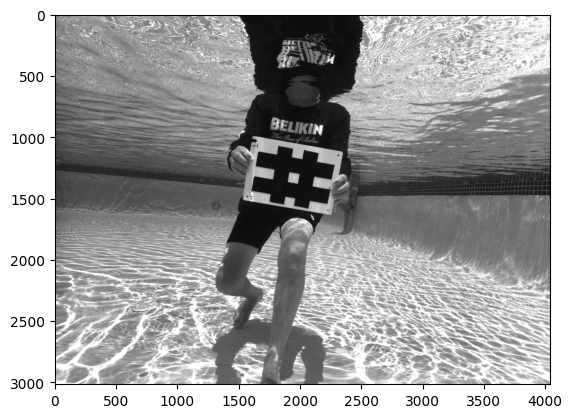

In [3]:
plt.imshow(test_img, cmap='gray')

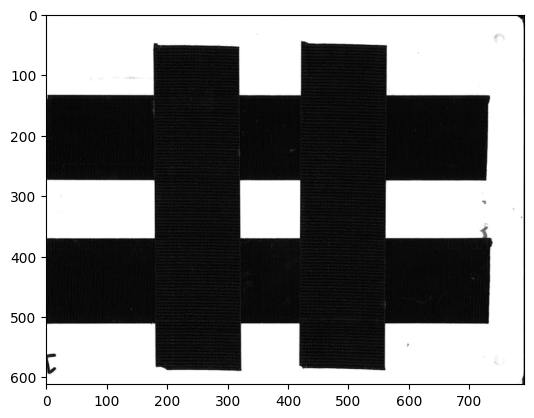

In [4]:
plt.imshow(slate_img, cmap='gray')

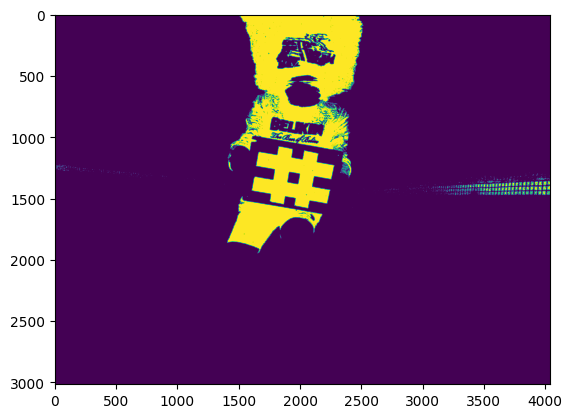

In [5]:
ret, thresholded = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresholded)

In [6]:
# get the largest contour from the original slate pdf
ret2, slate_threshold = cv2.threshold(slate_img, 100, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(slate_threshold, cv2.MORPH_OPEN, kernel)
slate_contours, slate_hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
slate_contour = None
for c in slate_contours:
    area = cv2.contourArea(c)
    if area > max_area:
        max_area = area
        slate_contour = c

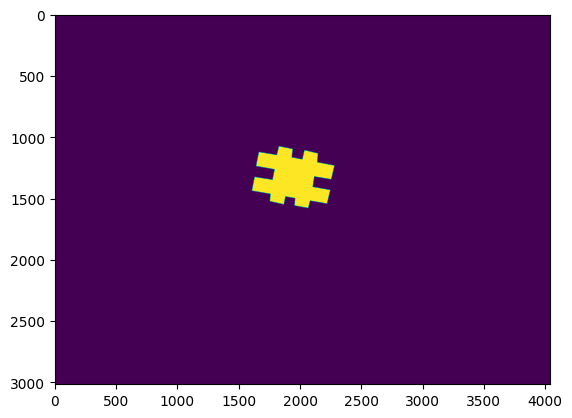

In [7]:
# get the matching contour in the calibration image
test_contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_score = np.inf
slate_in_image = None
for t in test_contours: 
    score = cv2.matchShapes(t, slate_contour, cv2.CONTOURS_MATCH_I2, 0.0)
    if score < min_score: 
        min_score = score
        slate_in_image = t

img_contour: np.ndarray = cv2.approxPolyDP(slate_in_image, 10, closed=True)
display = cv2.drawContours(np.zeros(test_img.shape), [img_contour], 0, 255, cv2.FILLED, 8)
plt.imshow(display)

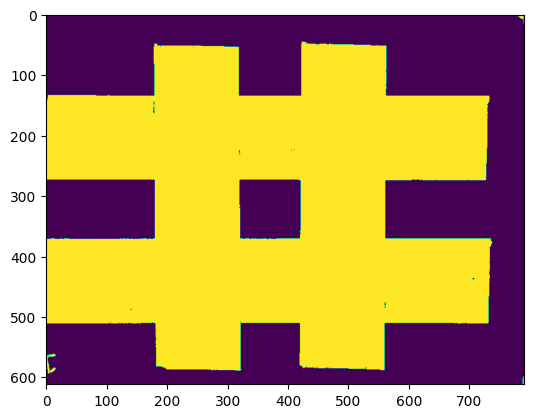

In [8]:
ret, pdf_threshold = cv2.threshold(slate_img, 50, 255, cv2.THRESH_BINARY_INV)
plt.imshow(pdf_threshold)

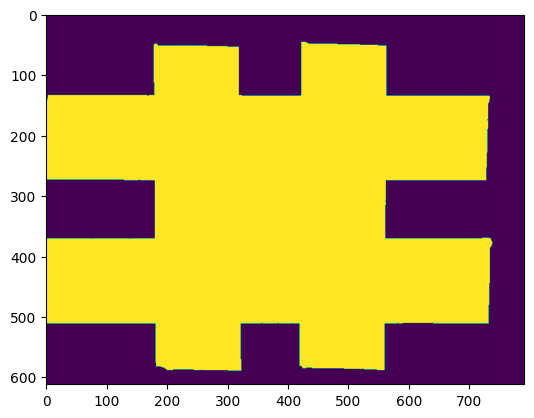

In [9]:
pdf_display = cv2.drawContours(np.zeros(pdf_threshold.shape), [slate_contour], 0, 255, cv2.FILLED, 8)
plt.imshow(pdf_display)

In [10]:
def error(img_contour: np.ndarray, slate_contour: np.ndarray):
    return scipy.spatial.distance.cdist(slate_contour.astype(float), img_contour.astype(float)).min(axis=1).mean() ** 2

def homo2contour(homogeneous_coords: np.ndarray):
    return np.round(homogeneous_coords[:, :2]).astype(int)

In [11]:
def calculate_transform(img_contour: np.ndarray, slate_contour: np.ndarray, angle: float):
    T = np.array([[cos(angle), -sin(angle), 0],
                  [sin(angle), cos(angle), 0],
                  [0, 0, 1]], dtype=float)
    
    slate_height, _, _ = slate_contour.shape
    slate_contour_homo = np.ones((slate_height, 3), dtype=float)
    slate_contour_homo[:, :2] = slate_contour.squeeze(1)

    transformed_slate_contour = (T @ slate_contour_homo.T).T

    img_radius = np.sqrt(cv2.contourArea(img_contour) / np.pi)
    slate_radius = np.sqrt(cv2.contourArea(homo2contour(transformed_slate_contour)) / np.pi)

    scale = img_radius / slate_radius

    T *= scale
    T[2, 2] = 1

    transformed_slate_contour = (T @ slate_contour_homo.T).T

    img_M = cv2.moments(img_contour)
    img_cx = int(img_M['m10']/img_M['m00'])
    img_cy = int(img_M['m01']/img_M['m00'])
    img_center = np.array([[img_cx], [img_cy]])

    slate_M = cv2.moments(homo2contour(transformed_slate_contour))
    slate_cx = int(slate_M['m10']/slate_M['m00'])
    slate_cy = int(slate_M['m01']/slate_M['m00'])
    slate_center = np.array([[slate_cx], [slate_cy]])

    T[:2, 2] = (img_center - slate_center).squeeze()

    return T

In [12]:
slate_height, _, _ = slate_contour.shape
slate_contour_homo = np.ones((slate_height, 3), dtype=float)
slate_contour_homo[:, :2] = slate_contour.squeeze(1)

In [13]:
_, _, img_angle = cv2.fitEllipse(img_contour)
_, _, slate_angle = cv2.fitEllipse(slate_contour)

angle_difference_one = (img_angle - slate_angle) * np.pi / 180.0

In [14]:
T_one = calculate_transform(img_contour, slate_contour, angle_difference_one)
T_two = calculate_transform(img_contour, slate_contour, np.pi + angle_difference_one)

In [15]:
transformed_slate_contour_one = (T_one @ slate_contour_homo.T).T
transformed_slate_contour_two = (T_two @ slate_contour_homo.T).T

In [16]:
error_one = error(img_contour.squeeze(1), homo2contour(transformed_slate_contour_one))
error_two = error(img_contour.squeeze(1), homo2contour(transformed_slate_contour_two))

error_one, error_two

(536.2972943465186, 611.9544103767093)

In [17]:
transformed_slate_contour = transformed_slate_contour_one if error_one < error_two else transformed_slate_contour_two
T = T_one if error_one < error_two else T_two


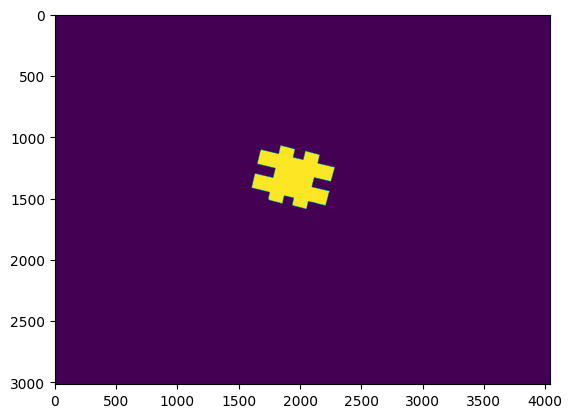

In [18]:
pdf_display = cv2.drawContours(np.zeros(test_img.shape), [homo2contour(transformed_slate_contour)], 0, 255, cv2.FILLED, 8)
plt.imshow(pdf_display)

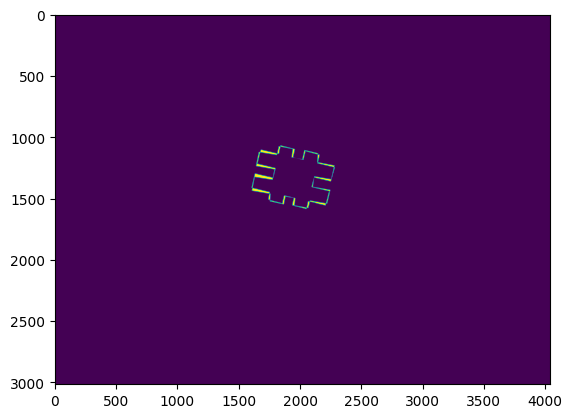

In [19]:
plt.imshow(np.abs(pdf_display - display))

In [20]:
scipy.spatial.distance.cdist(homo2contour(transformed_slate_contour).astype(float), img_contour.squeeze(1).astype(float)).argmin(axis=1)

array([22, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26,
       26, 27, 27, 27, 27, 27, 27, 27, 27,  0,  0,  0,  0,  0,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  5,  6,
        6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18,
       18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 21,
       21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22])